# 使用NEU-DET練習影像分類，模型設計調校

### 匯入函式庫

In [1]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf

In [3]:
#文件搜索的工具
import glob

#這是一個看迴圈進度條的小工具
from tqdm import tqdm 

#匯入電腦視覺的函式庫，作影像讀取和分析使用
import cv2

### 讀入一張影像測試與檢視

In [4]:
#讀一張影像試試

path_name='NEU-DET/train/images/crazing/crazing_1.jpg'
# path_name='chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = cv2.imread(path_name,cv2.IMREAD_GRAYSCALE)

#cv2.IMREAD_GRAYSCALE 以灰階的格式來讀取圖片。預設值為cv2.IMREAD_COLOR(讀取 RGB 三個 channels)

#其他的讀取方式：(1)matplotlib、(2)PIL
#import matplotlib.image as mpimg
#img = mpimg.imread(path_name)

#from PIL import Image
#img = Image.open(path_name)

In [5]:
mpl.rcParams['figure.figsize'] = (12,12) #畫布尺寸

img (x_dim, y_dim) and type:  (200, 200) uint8


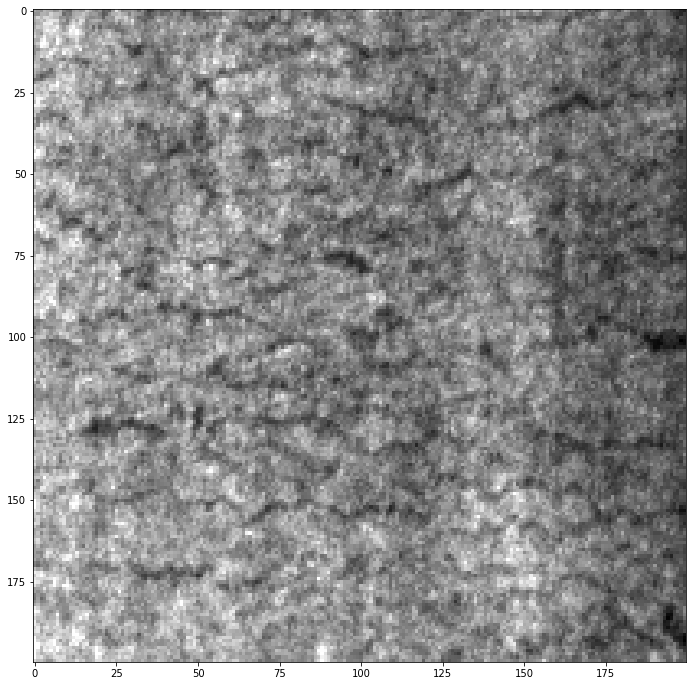

In [6]:
print('img (x_dim, y_dim) and type: ',img.shape, img.dtype)
plt.imshow(img, cmap='gray')

### 定義訓練資料

In [7]:
#欲分類的lable與數量
labels_name = os.listdir('./NEU-DET/train/images/')
num_classes = len(labels_name)

In [8]:
labels_name

['scratches',
 'inclusion',
 'rolled-in_scale',
 'crazing',
 'pitted_surface',
 'patches']

In [9]:
num_classes

6

In [10]:
#建立訓練資料所在的路徑位置與對應的label：(filelist, label)
#label為數字，0代表'NORMAL'、1代表'PNEUMONIA'
filelist = []
label = []
for i in labels_name:
    class_num = labels_name.index(i)
    pathfile = glob.glob('./NEU-DET/train/images/'+str(i)+'/*.jpg')
    
    for p in pathfile:
        filelist.append(p)
        label.append(class_num)

In [11]:
print('numbers of img:',len(filelist))

numbers of img: 1440


In [12]:
#影像縮放大小
desired_size = 200

In [13]:
#定義一個縮放影像(img)至指定大小(desired_size)的函數
#等比例縮小，其他地方補黑邊
def squared(img, desired_size):
    old_size = img.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_img

### 開始讀入影像

In [14]:
#先宣告一個指定大小的ndarray
all_data = np.zeros((len(filelist),desired_size,desired_size,3), dtype=np.float32)

In [15]:
#開始讀入影像
for i in tqdm(range(len(filelist))):
    img = cv2.imread(filelist[i], cv2.IMREAD_GRAYSCALE)
    new_img = squared(img, desired_size)

#進行正規化(normalization)，常用除255或z-score
    m = np.mean(new_img)
    s = np.std(new_img)
    t = (new_img-m)/s
#    t=new_img/255

#三個channel可給予不同的處理手法
    all_data[i,:,:,0]=t
    all_data[i,:,:,1]=t
    all_data[i,:,:,2]=t

100%|██████████| 1440/1440 [00:10<00:00, 136.31it/s]


In [16]:
label=np.array(label)

### 模型匯入與切分資料集

In [17]:
#以test_size的比例分訓練集和驗證集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, Y_test = train_test_split(all_data, label, test_size=0.2, random_state=90)  

In [18]:
#對類別資料作One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(Y_test)

## 建立AI模型

In [33]:
#撰寫模型
input_layer=tf.keras.layers.Input(shape=(desired_size,desired_size,3))

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)

x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(64, activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)

output_layer=tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [34]:
model=tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 64)        0   

In [35]:
#data augmentation相關設定
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)  

## 開始訓練

In [36]:
#告訴AI學習的方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [37]:
#將訓練的模型置放於model_path下的model_name
model_name = 'NEU'

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

In [38]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

In [39]:
#開始訓練，順便把訓練過程存到model_history，方便後續畫圖
model_history=model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=70, 
                        steps_per_epoch=len(x_train)/32, validation_data=(x_test,y_test), callbacks=[earlystop, checkpoint])

Epoch 1/70
36/36 [==============================] - 10s 260ms/step - loss: 1.9410 - categorical_accuracy: 0.2274 - val_loss: 1.5781 - val_categorical_accuracy: 0.4479

Epoch 00001: val_loss improved from inf to 1.57809, saving model to /home/robust5566/saved_models/NEU
INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 2/70
36/36 [==============================] - 7s 192ms/step - loss: 1.4921 - categorical_accuracy: 0.3620 - val_loss: 1.1313 - val_categorical_accuracy: 0.5972

Epoch 00002: val_loss improved from 1.57809 to 1.13135, saving model to /home/robust5566/saved_models/NEU
INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 3/70
36/36 [==============================] - 7s 193ms/step - loss: 1.2510 - categorical_accuracy: 0.4505 - val_loss: 1.1667 - val_categorical_accuracy: 0.5590

Epoch 00003: val_loss did not improve from 1.13135
Epoch 4/70
36/36 [==============================] - 7s 192ms/step - loss: 1.1050 - cate

## 畫圖

In [40]:
model_history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [41]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['categorical_accuracy']
val_acc = model_history.history['val_categorical_accuracy']

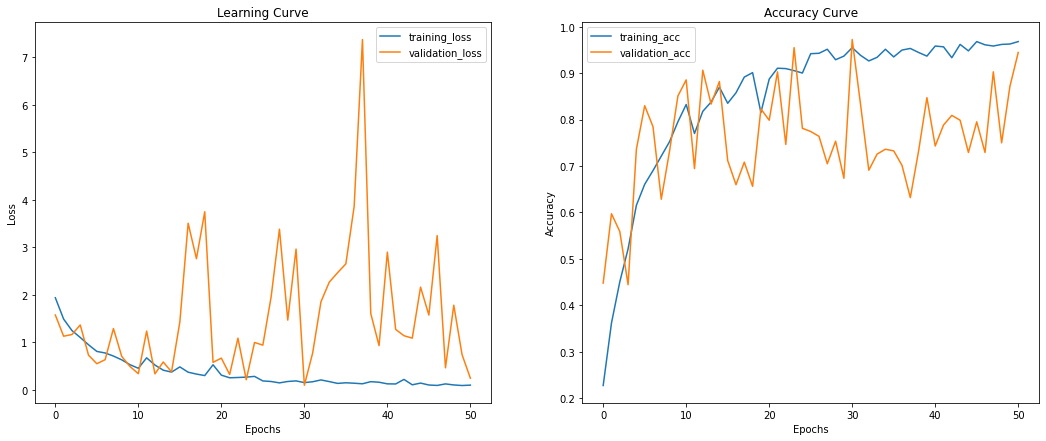

In [42]:
#畫圖
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc='best')

plt.show()

## 作預測

In [43]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

In [44]:
#使用AI模型作預測
pred=model.predict(x_test)

In [45]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

In [46]:
#畫出混淆矩陣
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, ans)
print(cf_matrix)

[[48  1  0  0  0  0]
 [ 0 41  0  0  0  2]
 [ 0  0 44  0  0  0]
 [ 0  0  2 44  0  0]
 [ 0  0  0  1 59  0]
 [ 0  0  1  1  0 44]]


<AxesSubplot:>

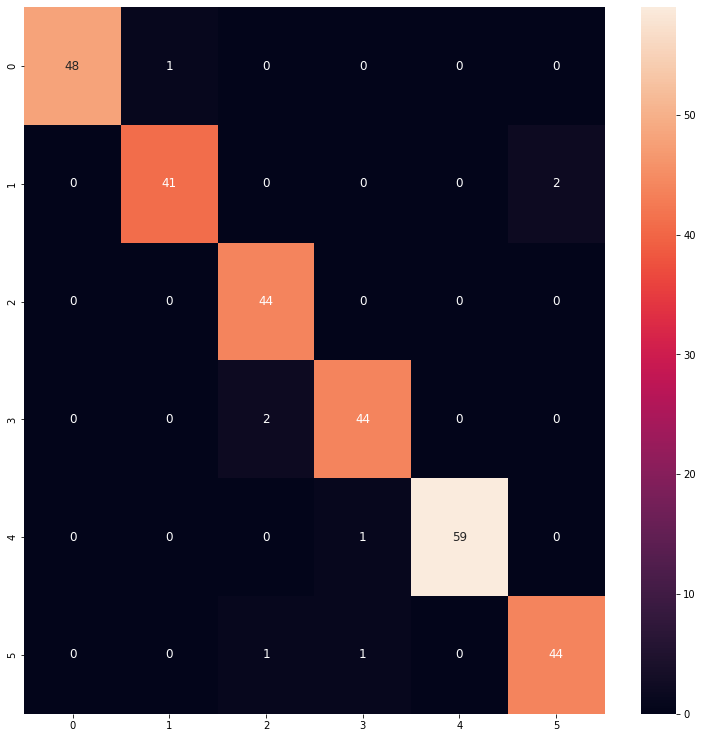

In [47]:
#對混淆矩陣畫圖
import seaborn as sns
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(cf_matrix, fmt='g', annot=True, annot_kws={"size":12})

In [48]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(Y_test, ans)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       0.98      0.95      0.96        43
           2       0.94      1.00      0.97        44
           3       0.96      0.96      0.96        46
           4       1.00      0.98      0.99        60
           5       0.96      0.96      0.96        46

    accuracy                           0.97       288
   macro avg       0.97      0.97      0.97       288
weighted avg       0.97      0.97      0.97       288

